In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmcrameri import cm
import babet as bb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
import metpy.calc as mpcalc 
from metpy.units import units

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

# Import data

In [2]:
# Import forecast data 
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/pl/pf'
exp = {}
for experiment in experiments:
    exp[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds)

In [3]:
# Import forecast data at surface
base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/EU025/sfc/pf'
exp_sfc = {}
for experiment in experiments:
    exp_sfc[experiment] = xr.open_mfdataset(os.path.join(base_dir.format(experiment), '*.nc'), preprocess=bb.Data.preproc_ds)

In [4]:
# Import ERA5 data
era5_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5/EU025/pl/'
era5 = xr.open_mfdataset(os.path.join(era5_dir, '*.nc'))
era5 = era5.sel(time=slice('2023-10-17 00', '2023-10-23 00'))

In [5]:
# Plot settings

# UK
lat_max = 60
lat_min = 42
lon_min = -12
lon_max = 5

# #Europe
# lat_max = 70
# lat_min = 33
# lon_min = -27
# lon_max = 25

euroatlantic = [lon_min-13, lon_max, lat_min-5, lat_max+6]
uk = [-11, 10, 48, 70]
northsea = [-17, 20, 40, 70]

# Humidity advection calculation

In [6]:
def calc_advection_q(ds, level=850):
    '''
    Calculate scalar horizontal advection of q
    on a pressure level

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing u, v and q variables
    level : int, optional
        Pressure level to calculate advection, by default 850

    Returns
    -------
    xarray.DataArray
        Scalar advection
    '''
    # Calculate gradient of q
    dqdlon =ds.sel(level=level).q.diff(n=2, dim='longitude') / bb.met.Met.haversine(ds.sel(level=level).latitude, ds.sel(level=level).longitude.values[:-2], ds.sel(level=level).latitude, ds.sel(level=level).longitude[2:])
    dqdlat = ds.sel(level=level).q.diff(n=2, dim='latitude') / bb.met.Met.haversine(ds.sel(level=level).latitude.values[:-2], ds.sel(level=level).longitude, ds.sel(level=level).latitude[2:], ds.sel(level=level).longitude)
    
    # Calculate advection
    adv = (ds.sel(level=level).u.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlon) + (ds.sel(level=level).v.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlat)
    return adv

In [7]:
# Calculate scalar advection
level = 850
adv = {}
for experiment in experiments:
    adv[experiment] = calc_advection_q(exp[experiment], level=level) 

# Calculate unit vector of wind
u = {}
v = {}
for experiment in experiments:
    u[experiment] = (exp[experiment].u / np.sqrt(exp[experiment].u**2 + exp[experiment].v**2)).sel(level=level).isel(latitude=slice(1, -1), longitude=slice(1, -1))
    v[experiment] = (exp[experiment].v / np.sqrt(exp[experiment].u**2 + exp[experiment].v**2)).sel(level=level).isel(latitude=slice(1, -1), longitude=slice(1, -1))

# Using humidity advection to separate dynamics and thermodynamics

In [8]:
def calc_dynamic_adv(dict_ds, experiment, level=850): 

    q_bar = dict_ds['curr']
    u_prime = dict_ds[experiment] - dict_ds['curr']

    # Calculate gradient of q
    dqdlon =q_bar.sel(level=level).q.diff(n=2, dim='longitude') / bb.met.Met.haversine(q_bar.sel(level=level).latitude, q_bar.sel(level=level).longitude.values[:-2], q_bar.sel(level=level).latitude, q_bar.sel(level=level).longitude[2:])
    dqdlat = q_bar.sel(level=level).q.diff(n=2, dim='latitude') / bb.met.Met.haversine(q_bar.sel(level=level).latitude.values[:-2], q_bar.sel(level=level).longitude, q_bar.sel(level=level).latitude[2:], q_bar.sel(level=level).longitude)
    
    # Calculate advection
    adv = (u_prime.sel(level=level).u.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlon) + (u_prime.sel(level=level).v.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlat)
    return adv

In [9]:
def calc_thermodynamic_adv(dict_ds, experiment, level=850): 

    q_prime = dict_ds[experiment] - dict_ds['curr']
    u_bar = dict_ds['curr'] # all variables entailed so no need for v_bar here

    # Calculate gradient of q
    dqdlon =q_prime.sel(level=level).q.diff(n=2, dim='longitude') / bb.met.Met.haversine(q_prime.sel(level=level).latitude, q_prime.sel(level=level).longitude.values[:-2], q_prime.sel(level=level).latitude, q_prime.sel(level=level).longitude[2:])
    dqdlat = q_prime.sel(level=level).q.diff(n=2, dim='latitude') / bb.met.Met.haversine(q_prime.sel(level=level).latitude.values[:-2], q_prime.sel(level=level).longitude, q_prime.sel(level=level).latitude[2:], q_prime.sel(level=level).longitude)
    
    # Calculate advection
    adv = (u_bar.sel(level=level).u.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlon) + (u_bar.sel(level=level).v.isel(latitude=slice(1, -1), longitude=slice(1, -1)) * dqdlat)
    return adv

In [10]:
adv_dynamic = {}
adv_thermodynamic = {}
level = 925

for experiment in ['pi', 'incr']: 
    adv_dynamic[experiment] = calc_dynamic_adv(exp, experiment, level=level)
    adv_thermodynamic[experiment] = calc_thermodynamic_adv(exp, experiment, level=level)

In [11]:
# # Save data for plot
# adv_dynamic_vals_dict = {exp_key: {ini_key: adv_dynamic[exp_key].sel(time=slice(starttime, endtime), inidate=ini_key).mean(['number', 'time']).squeeze().values for ini_key in ['2023-10-15', '2023-10-17']} for exp_key in adv_dynamic.keys()}
# adv_thermodynamic_vals_dict = {exp_key: {ini_key: adv_thermodynamic[exp_key].sel(time=slice(starttime, endtime), inidate=ini_key).mean(['number', 'time']).squeeze().values for ini_key in ['2023-10-15', '2023-10-17']} for exp_key in adv_thermodynamic.keys()}

# np.save(f'../data/09_advection_dynamic_vals_level{level}.npy', adv_dynamic_vals_dict)
# np.save(f'../data/09_advection_thermodynamic_vals_level{level}.npy', adv_thermodynamic_vals_dict)

In [12]:
# Load data for plot
level = 850
adv_dynamic_vals_dict = np.load(f'../data/09_advection_dynamic_vals_level{level}.npy', allow_pickle=True).item()
adv_thermodynamic_vals_dict = np.load(f'../data/09_advection_thermodynamic_vals_level{level}.npy', allow_pickle=True).item()

In [13]:
data_saved = True

# Reload data for plot
adv_vals_dict = np.load('../data/09_advection_vals.npy', allow_pickle=True).item()
u_vals_dict = np.load('../data/09_u_vals.npy', allow_pickle=True).item()
v_vals_dict = np.load('../data/09_v_vals.npy', allow_pickle=True).item()
adv_era5_vals = np.load('../data/09_advection_era5_vals.npy')
u_era5_vals = np.load('../data/09_u_era5_vals.npy')
v_era5_vals = np.load('../data/09_v_era5_vals.npy')

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


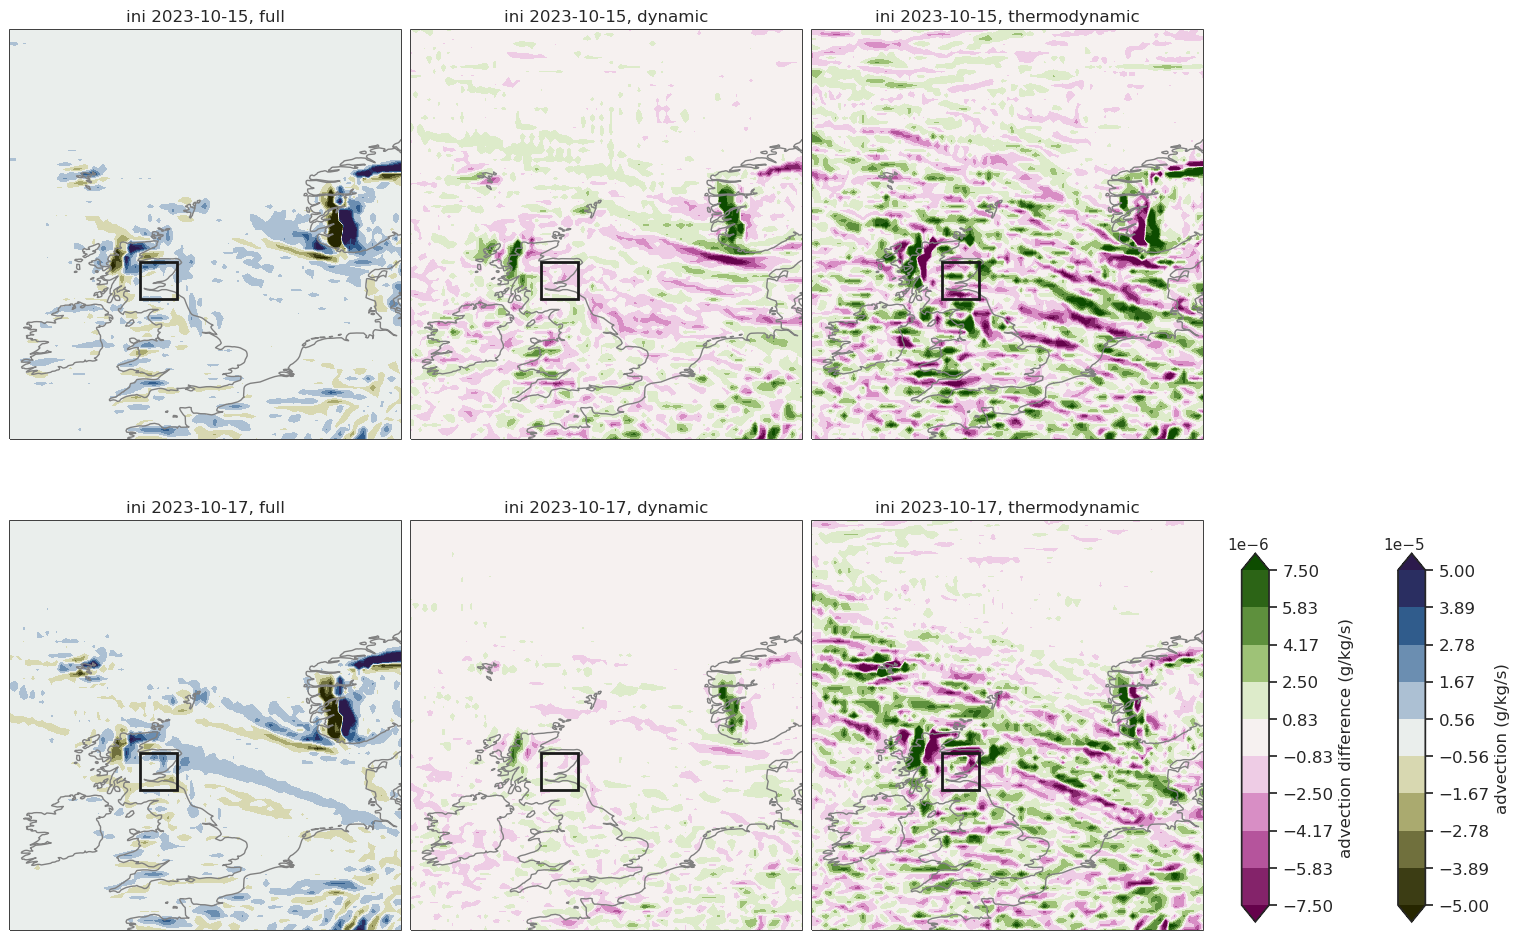

In [20]:
# pi: full, dynamic, thermodynamic for two inidates
inidates = ['2023-10-15', '2023-10-17']
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'
fs = 15

fig = plt.figure(1, figsize=(15, 10))
projection = ccrs.PlateCarree()
adv_min = -0.00005
adv_max = 0.00005
clevs_adv = np.linspace(adv_min, adv_max, 10)

latitude = adv['curr'].latitude.values
longitude = adv['curr'].longitude.values

for i, inidate in enumerate(inidates):

    # full change in advection
    clevs_adv = np.linspace(adv_min, adv_max, 10)
    ax1 = plt.subplot(2,3, 1+i*3,projection = projection)
    ax1.set_extent(uk, projection)
    adv_vals = adv_vals_dict['pi'][inidate]
    cf = ax1.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.broc_r,
                      transform=projection, zorder = 10, extend = 'both')
    ax1.set_title(f'ini {inidate}, full')
    ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax1.add_patch(rectangle)
    rectangle.set_zorder(17)

    # dynamic change in advection
    clevs_adv = np.linspace(adv_max*(-0.15), adv_max*0.15, 10)    
    ax2 = plt.subplot(2,3, 2+i*3,projection = projection)
    ax2.set_extent(uk, projection)
    adv_vals = adv_dynamic_vals_dict['pi'][inidate]
    cf_diff = ax2.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.bam,
                          transform=projection, zorder = 10, extend = 'both')
    ax2.set_title(f'ini {inidate}, dynamic')
    ax2.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax2.add_patch(rectangle)
    rectangle.set_zorder(17)

    # thermodynamic change in advection
    clevs_adv = np.linspace(adv_max*(-0.15), adv_max*0.15, 10)
    ax3 = plt.subplot(2,3, 3+i*3,projection = projection)
    ax3.set_extent(uk, projection)
    adv_vals = adv_thermodynamic_vals_dict['pi'][inidate]
    cf_diff = ax3.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.bam,
                          transform=projection, zorder = 10, extend = 'both')
    ax3.set_title(f'ini {inidate}, thermodynamic')
    ax3.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax3.add_patch(rectangle)
    rectangle.set_zorder(17)

# colourbars
cax_diff = ax3.inset_axes([1.1, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='advection difference (g/kg/s)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='advection difference (g/kg/s)', size=fs-3)
cbar_diff.ax.tick_params(labelsize=fs-3)

cax = ax3.inset_axes([1.5, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='advection (g/kg/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='advection (g/kg/s)', size=fs-3)
cbar.ax.tick_params(labelsize=fs-3)

plt.tight_layout()
# plt.suptitle('Advection difference at 850hPa for PI')
# plt.savefig(f'figures/11_advection_pi_dyn-therm_level{level}.png', dpi=600)
# plt.savefig(f'figures/11_advection_pi_dyn-therm_level{level}.pdf')


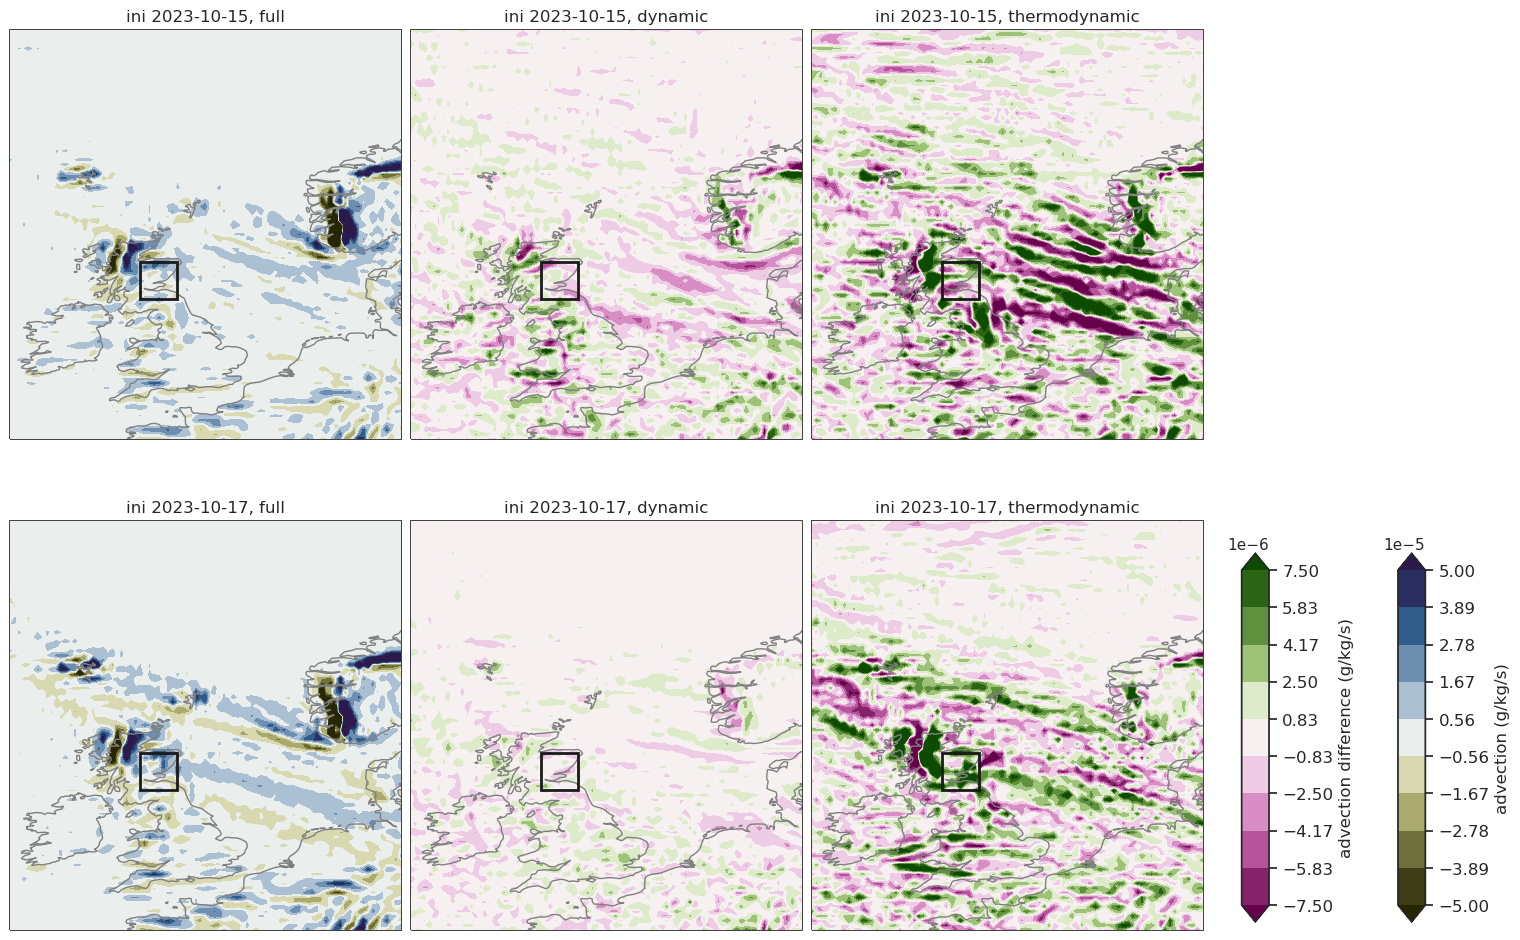

In [ ]:
# incr: full, dynamic, thermodynamic for two inidates
inidates = ['2023-10-15', '2023-10-17']
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'
fs = 15

fig = plt.figure(1, figsize=(15, 10))
projection = ccrs.PlateCarree()
adv_min = -0.00005
adv_max = 0.00005
clevs_adv = np.linspace(adv_min, adv_max, 10)

latitude = adv['curr'].latitude.values
longitude = adv['curr'].longitude.values

for i, inidate in enumerate(inidates):

    # full change in advection
    clevs_adv = np.linspace(adv_min, adv_max, 10)
    ax1 = plt.subplot(2,3, 1+i*3,projection = projection)
    ax1.set_extent(uk, projection)
    adv_vals = adv_vals_dict['incr'][inidate]
    cf = ax1.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.broc_r,
                      transform=projection, zorder = 10, extend = 'both')
    ax1.set_title(f'ini {inidate}, full')
    ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax1.add_patch(rectangle)
    rectangle.set_zorder(17)

    # dynamic change in advection
    clevs_adv = np.linspace(adv_max*(-0.15), adv_max*0.15, 10)    
    ax2 = plt.subplot(2,3, 2+i*3,projection = projection)
    ax2.set_extent(uk, projection)
    adv_vals = adv_dynamic_vals_dict['incr'][inidate]
    cf_diff = ax2.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.bam,
                          transform=projection, zorder = 10, extend = 'both')
    ax2.set_title(f'ini {inidate}, dynamic')
    ax2.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax2.add_patch(rectangle)
    rectangle.set_zorder(17)

    # thermodynamic change in advection
    clevs_adv = np.linspace(adv_max*(-0.15), adv_max*0.15, 10)
    ax3 = plt.subplot(2,3, 3+i*3,projection = projection)
    ax3.set_extent(uk, projection)
    adv_vals = adv_thermodynamic_vals_dict['incr'][inidate]
    cf_diff = ax3.contourf(longitude, latitude, adv_vals, clevs_adv, cmap=cm.bam,
                          transform=projection, zorder = 10, extend = 'both')
    ax3.set_title(f'ini {inidate}, thermodynamic')
    ax3.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax3.add_patch(rectangle)
    rectangle.set_zorder(17)

# colourbars
cax_diff = ax3.inset_axes([1.1, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar_diff = fig.colorbar(cf_diff, cax=cax_diff, label='advection difference (g/kg/s)', extend = 'both', shrink=0.8)
cbar_diff.set_label(label='advection difference (g/kg/s)', size=fs-3)
cbar_diff.ax.tick_params(labelsize=fs-3)

cax = ax3.inset_axes([1.5, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(cf, cax=cax, label='advection (g/kg/s)', extend = 'both', shrink=0.8)
cbar.set_label(label='advection (g/kg/s)', size=fs-3)
cbar.ax.tick_params(labelsize=fs-3)

plt.tight_layout()
# plt.suptitle('Advection difference at 850hPa for INCR')
# plt.savefig(f'figures/11_advection_incr_dyn-therm_level{level}.png', dpi=600)
# plt.savefig(f'figures/11_advection_incr_dyn-therm_level{level}.pdf')

# Vertical velocity and specific humidity


$$\langle w \rangle = \frac{\int w \cdot \Delta P}{\int \Delta P}$$


In [8]:
def calc_average_w(ds, lower=850, upper=250):
    
    ds = ds.copy(deep=True).sel(level=slice(upper, lower))
    
    # Compute the pressure thickness (ΔP) between levels
    # The last dimension should be the pressure dimension
    delta_p = ds.level.diff('level').rename('delta_p')

    # Align ΔP with the original dataset (it will be one less in size)
    delta_p = delta_p.assign_coords(p=ds['level'].isel(level=slice(1, None)))

    # Compute the mass-weighted vertical velocity
    weighted_w = ds['w'].isel(level=slice(1, None)) * delta_p

    # Compute the mass-weighted average
    mass_weighted_average = (weighted_w.sum(dim='level') / delta_p.sum(dim='level')).rename('mass_weighted_w')

    # Add the result to your dataset
    ds['mass_weighted_w'] = mass_weighted_average
    
    return ds


In [9]:
def calc_qs(ds):

    # Constants
    epsilon = 0.622  # Ratio of gas constants (R_v / R_d)
    R_d = 287.05  # Gas constant for dry air (J/kg/K)
    R_v = 461.5  # Gas constant for water vapor (J/kg/K)

    # Assume your dataset `ds` contains:
    # - 'T': temperature (Kelvin)
    # - 'p': pressure (Pa)

    # Convert temperature from Kelvin to Celsius
    T_c = ds['t'] - 273.15

    # Compute saturation vapor pressure (e_s) in hPa
    e_s_hpa = 6.112 * np.exp((17.67 * T_c) / (T_c + 243.5))

    # Convert saturation vapor pressure to Pa
    e_s = e_s_hpa * 100  # Convert hPa to Pa

    # Compute saturation specific humidity (q_s)
    q_s = (epsilon * e_s) / (ds['level'] - (1 - epsilon) * e_s)

    # Add q_s to the dataset
    ds['q_s'] = q_s
    
    return ds

In [10]:
def integate_qs(ds, lower=850, upper=250):
    # Constants
    g = 9.81  # gravitational acceleration in m/s^2

    # Assume `ds` is your xarray Dataset with:
    # - 'q_s': saturation specific humidity (kg/kg)
    # - 'p': pressure levels (Pa), sorted from top to bottom

    # Calculate saturation specific humidity at each level
    ds = calc_qs(ds).copy(deep=True).sel(level=slice(upper, lower))

    # Compute pressure thickness (Δp) for each layer
    delta_p = ds['level'].diff('level').rename('delta_p')

    # Align Δp to match dimensions of q_s (it will have one fewer element)
    delta_p = delta_p.assign_coords(p=ds['level'].isel(level=slice(1, None)))

    # Compute the weighted saturation specific humidity (q_s * Δp)
    weighted_qs = ds['q_s'].isel(level=slice(1, None)) * delta_p

    # Integrate vertically by summing over the pressure dimension
    vertically_integrated_qs = (weighted_qs.sum(dim='level') / g).rename('Q_s')

    # Add the result to the dataset for further use
    ds['Q_s'] = vertically_integrated_qs

    return ds

In [11]:
# plot Q_s and w changes
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'
exp = {exp_key: integate_qs(calc_average_w(exp[exp_key])) for exp_key in exp.keys()}
Q_s_dict = {exp_key: {ini_key: (exp[exp_key]-exp['curr']).Q_s.sel(inidate=ini_key, time=slice(starttime, endtime)).mean(dim=['time', 'number']).squeeze() for ini_key in ['2023-10-15', '2023-10-17']} for exp_key in exp.keys()}
w_dict = {exp_key: {ini_key: (exp[exp_key]-exp['curr']).mass_weighted_w.sel(inidate=ini_key, time=slice(starttime, endtime)).mean(dim=['time', 'number']).squeeze() for ini_key in ['2023-10-15', '2023-10-17']} for exp_key in exp.keys()}

# save data for plot
np.save('../data/11_Q_s_vals.npy', Q_s_dict)
np.save('../data/11_w_vals.npy', w_dict)

In [12]:
# Load data for plot
Q_s_dict = np.load('../data/11_Q_s_vals.npy', allow_pickle=True).item()
w_dict = np.load('../data/11_w_vals.npy', allow_pickle=True).item()

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


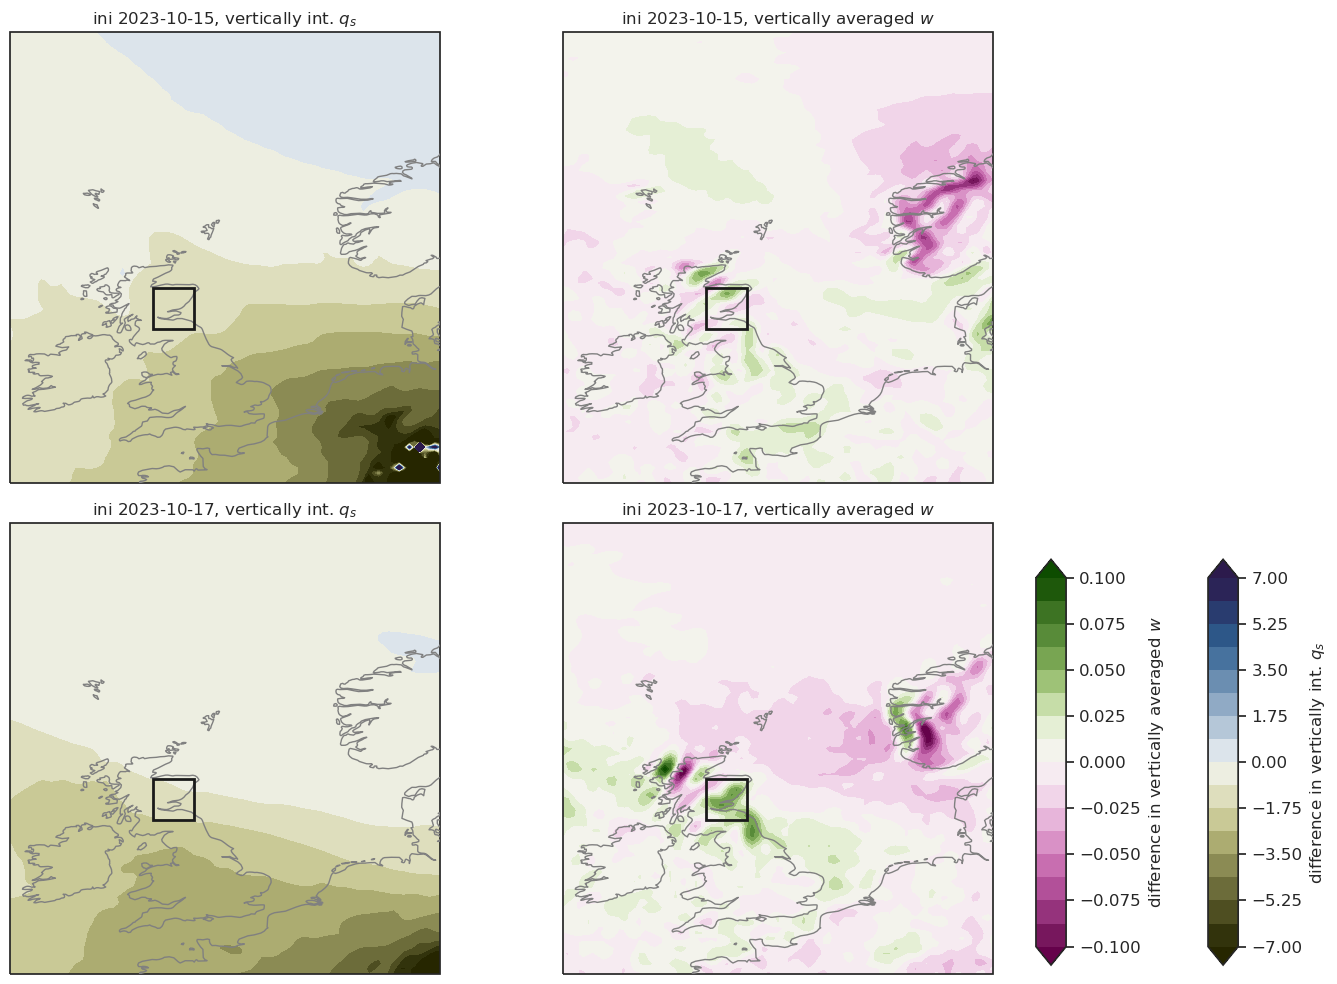

In [13]:
# plot Q_s and w changes for pi 
exp = {exp_key: integate_qs(calc_average_w(exp[exp_key])) for exp_key in exp.keys()}

inidates = ['2023-10-15', '2023-10-17']
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

fig = plt.figure(1, figsize=(15, 10))
projection = ccrs.PlateCarree()
fs = 15

w_min = -0.1
w_max = 0.1
clevs_w = np.linspace(w_min, w_max, 17)

qs_min = -7
qs_max = 7
clevs_qs = np.linspace(qs_min, qs_max, 17)


for i, inidate in enumerate(inidates):
    ax1 = plt.subplot(2, 2, 2*i+1, projection=projection)
    c_qs = ax1.contourf(exp['pi'].longitude, exp['pi'].latitude, Q_s_dict['pi'][inidate], 
                        clevs_qs, cmap=cm.broc_r, 
                        transform=projection, 
                        extend='both')
    ax1.set_title(rf'ini {inidate}, vertically int. $q$')
    ax1.set_extent(uk, projection)
    ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax1.add_patch(rectangle)
    rectangle.set_zorder(17)

    ax2 = plt.subplot(2, 2, 2*i+2, projection=projection)
    c_w = ax2.contourf(exp['pi'].longitude, exp['pi'].latitude, w_dict['pi'][inidate], 
                       clevs_w, cmap=cm.bam, 
                       transform=projection, 
                       extend='both')
    ax2.set_title(rf'ini {inidate}, vertically averaged $w$')
    ax2.set_extent(uk, projection)
    ax2.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax2.add_patch(rectangle)
    rectangle.set_zorder(17)

# colourbars
cax = ax2.inset_axes([1.1, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(c_w, cax=cax, label=rf'difference in vertically averaged $w$', extend = 'both', shrink=0.8)
cbar.set_label(label=rf'difference in vertically averaged $w$', size=fs-3)
cbar.ax.tick_params(labelsize=fs-3)

cax = ax2.inset_axes([1.5, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(c_qs, cax=cax, label=rf'difference in vertically int. $q$', extend = 'both', shrink=0.8)
cbar.set_label(label=rf'difference in vertically int. $q$', size=fs-3)
cbar.ax.tick_params(labelsize=fs-3)

plt.tight_layout()


/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


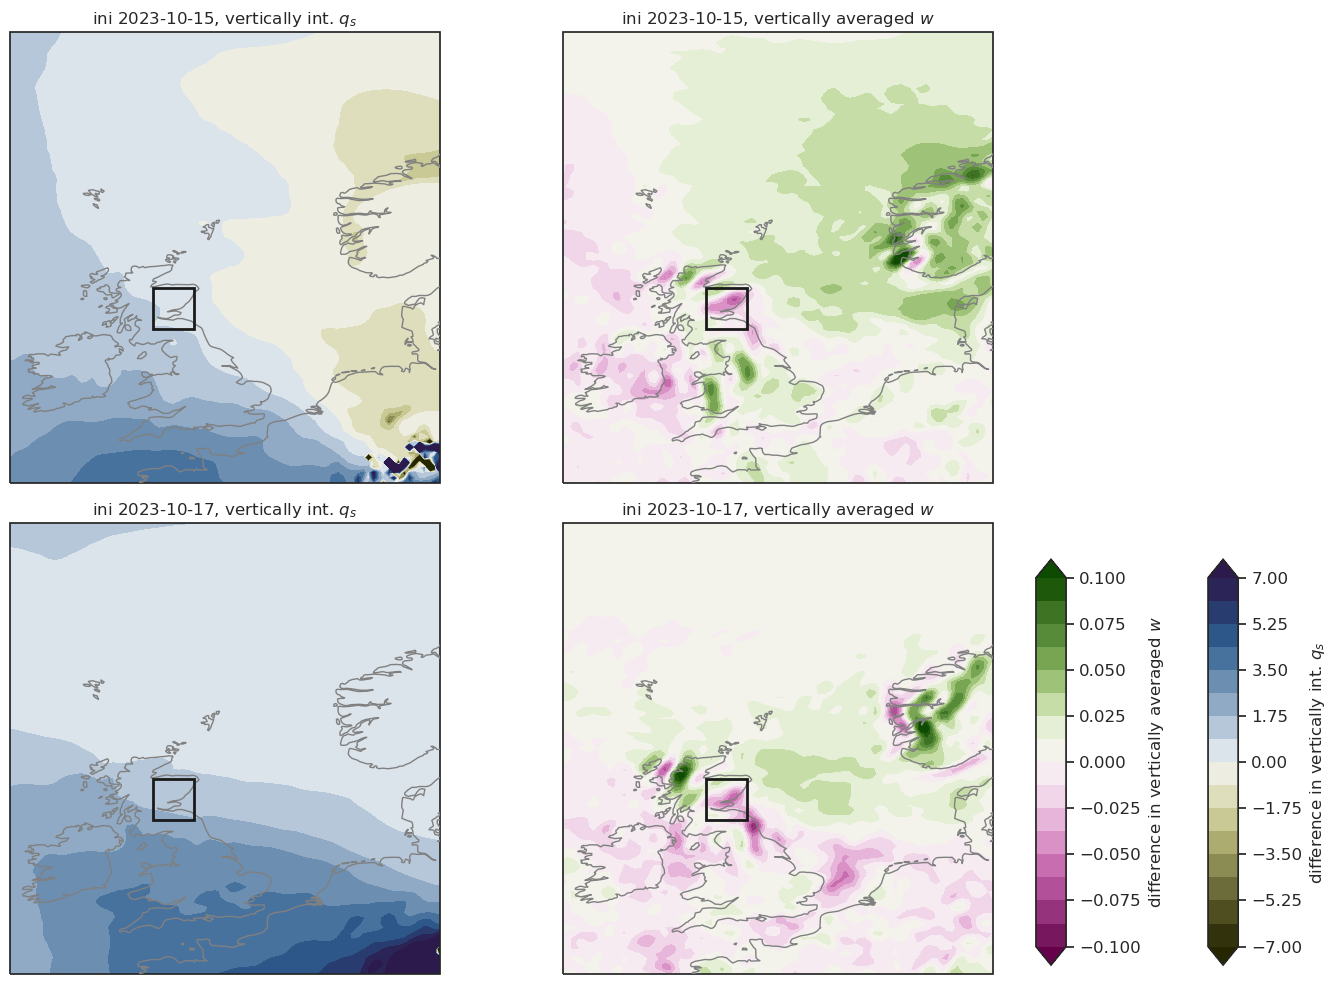

In [14]:
# plot Q_s and w changes for incr
exp = {exp_key: integate_qs(calc_average_w(exp[exp_key])) for exp_key in exp.keys()}

inidates = ['2023-10-15', '2023-10-17']
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

fig = plt.figure(1, figsize=(15, 10))
projection = ccrs.PlateCarree()
fs = 15

w_min = -0.1
w_max = 0.1
clevs_w = np.linspace(w_min, w_max, 17)

qs_min = -7
qs_max = 7
clevs_qs = np.linspace(qs_min, qs_max, 17)


for i, inidate in enumerate(inidates):
    ax1 = plt.subplot(2, 2, 2*i+1, projection=projection)
    c_qs = ax1.contourf(exp['incr'].longitude, exp['incr'].latitude, Q_s_dict['incr'][inidate], 
                        clevs_qs, cmap=cm.broc_r, 
                        transform=projection, 
                        extend='both')
    ax1.set_title(rf'ini {inidate}, vertically int. $q_s$')
    ax1.set_extent(uk, projection)
    ax1.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax1.add_patch(rectangle)
    rectangle.set_zorder(17)

    ax2 = plt.subplot(2, 2, 2*i+2, projection=projection)
    c_w = ax2.contourf(exp['incr'].longitude, exp['incr'].latitude, w_dict['incr'][inidate], 
                       clevs_w, cmap=cm.bam, 
                       transform=projection, 
                       extend='both')
    ax2.set_title(rf'ini {inidate}, vertically averaged $w$')
    ax2.set_extent(uk, projection)
    ax2.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
    rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                edgecolor='k', 
                                facecolor='none',
                                transform=projection)
    ax2.add_patch(rectangle)
    rectangle.set_zorder(17)

# colourbars
cax = ax2.inset_axes([1.1, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(c_w, cax=cax, label=rf'difference in vertically averaged $w$', extend = 'both', shrink=0.8)
cbar.set_label(label=rf'difference in vertically averaged $w$', size=fs-3)
cbar.ax.tick_params(labelsize=fs-3)

cax = ax2.inset_axes([1.5, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(c_qs, cax=cax, label=rf'difference in vertically int. $q_s$', extend = 'both', shrink=0.8)
cbar.set_label(label=rf'difference in vertically int. $q_s$', size=fs-3)
cbar.ax.tick_params(labelsize=fs-3)

plt.tight_layout()

# Compare $w$ in larger area

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


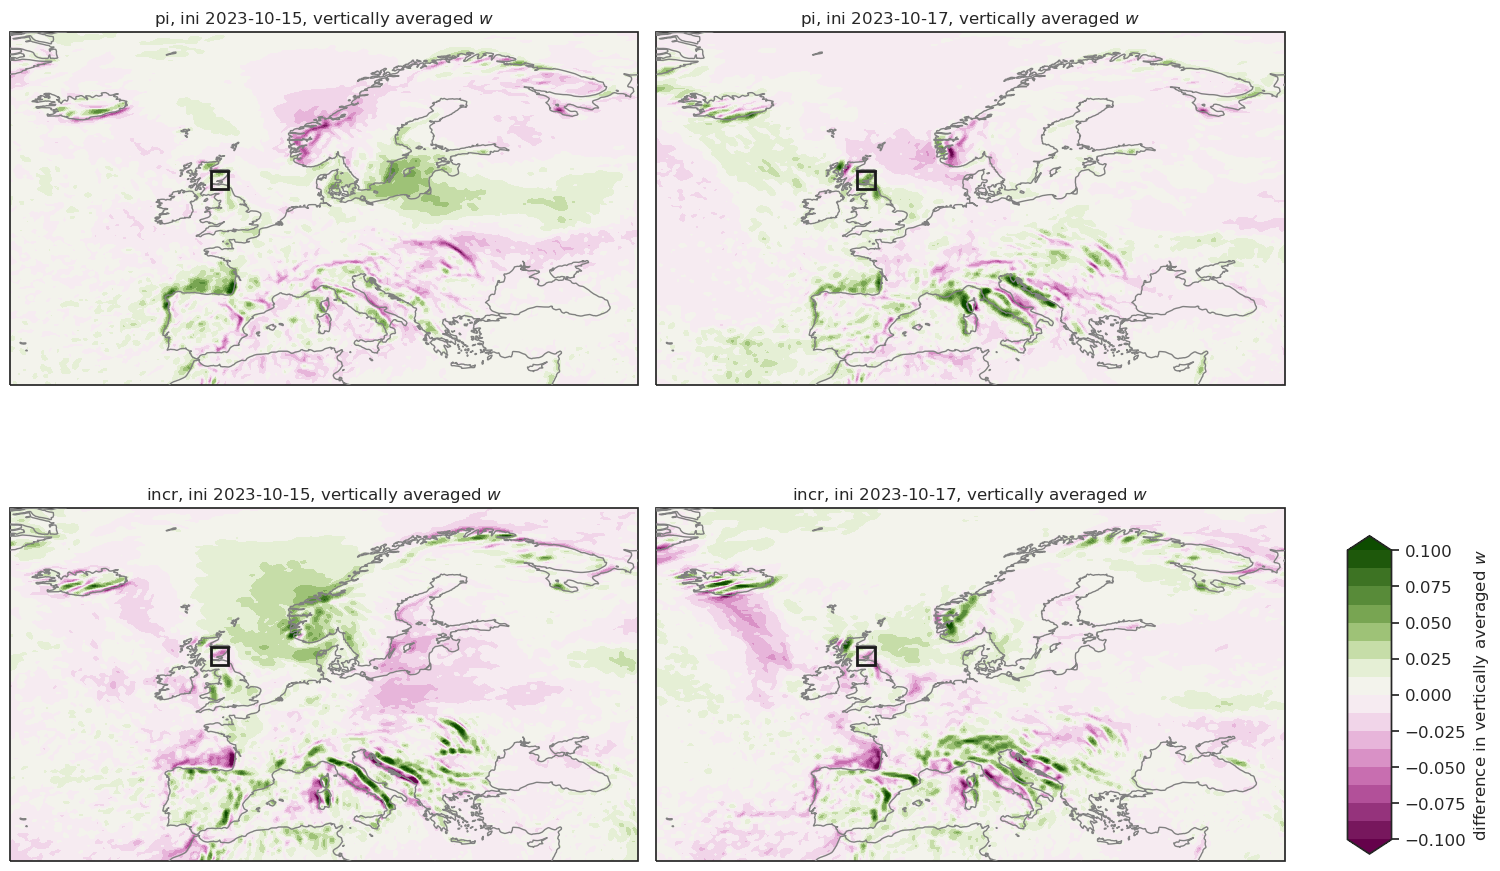

In [15]:
# changes in w for pi and incr
exp = {exp_key: integate_qs(calc_average_w(exp[exp_key])) for exp_key in exp.keys()}

inidates = ['2023-10-15', '2023-10-17']
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

fig = plt.figure(1, figsize=(15, 10))
projection = ccrs.PlateCarree()
fs = 15

w_min = -0.1
w_max = 0.1
clevs_w = np.linspace(w_min, w_max, 17)


for e, experiment in enumerate(['pi', 'incr']):
    for i, inidate in enumerate(inidates):
        ax2 = plt.subplot(2, 2, e*2+i+1, projection=projection)
        c_w = ax2.contourf(exp[experiment].longitude, exp[experiment].latitude, w_dict[experiment][inidate], 
                        clevs_w, cmap=cm.bam, 
                        transform=projection, 
                        extend='both')
        ax2.set_title(rf'{experiment}, ini {inidate}, vertically averaged $w$')
        # ax2.set_extent(uk, projection)
        ax2.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)
        rectangle = patches.Rectangle((-4, 55.5), 2, 2, linewidth=2, 
                                    edgecolor='k', 
                                    facecolor='none',
                                    transform=projection)
        ax2.add_patch(rectangle)
        rectangle.set_zorder(17)

# colourbars
cax = ax2.inset_axes([1.1, 0.02, 0.07, 0.9])  # creates inset, [x0,y0, width, height]
cbar = fig.colorbar(c_w, cax=cax, label=rf'difference in vertically averaged $w$', extend = 'both', shrink=0.8)
cbar.set_label(label=rf'difference in vertically averaged $w$', size=fs-3)
cbar.ax.tick_params(labelsize=fs-3)

plt.tight_layout()